In [87]:
import matplotlib.pyplot as plt

# Result

- Last value

    - Mean Absolute Error (MAE): 12.23

    - Root Mean Squared Error (RMSE): 18.33

    - Symmetric Mean Absolute Percentage Error (sMAPE): 30.59

In [88]:
import tensorflow as tf
import numpy as np
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Baseline

In [89]:
%run utils.ipynb

In [90]:
df_ori = load_data('df_actual_22_24_cleaned')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    24840 non-null  float64
 1   solar                    24840 non-null  int64  
 2   wind_onshore             24840 non-null  int64  
 3   wind_offshore            24840 non-null  int64  
 4   total_load               24840 non-null  int64  
 5   actual_solar             24840 non-null  int64  
 6   actual_wind_onshore      24840 non-null  int64  
 7   actual_wind_offshore     24840 non-null  int64  
 8   actual_fossil_gas        24840 non-null  int64  
 9   actual_fossil_hard_coal  24840 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 2.1 MB
None


In [91]:
train_df = df_ori.loc['2022-01-01 01:00:00': '2024-01-01 00:00:00', ['price']]
test_df = df_ori.loc['2024-01-01 01:00:00': '2024-11-01 01:00:00', ['price']]

In [92]:
historical_mean = np.mean(train_df['price'])
historical_mean

168.87087442922376

In [93]:
test_df.loc[:,'pred_mean'] = historical_mean
test_df.head()

,price,pred_mean
2024-01-01 01:00:00,0.10,168.870874
2024-01-01 02:00:00,0.01,168.870874
2024-01-01 03:00:00,0.00,168.870874
2024-01-01 04:00:00,-0.01,168.870874
2024-01-01 05:00:00,-0.03,168.870874


In [94]:
eva_s(test_df['price'], test_df['pred_mean'])

Mean Absolute Error (MAE): 99.05
Root Mean Squared Error (RMSE): 106.77
Symmetric Mean Absolute Percentage Error (sMAPE): 88.93


(99.0529459577813, 106.76812826648356, 88.93487989850996)

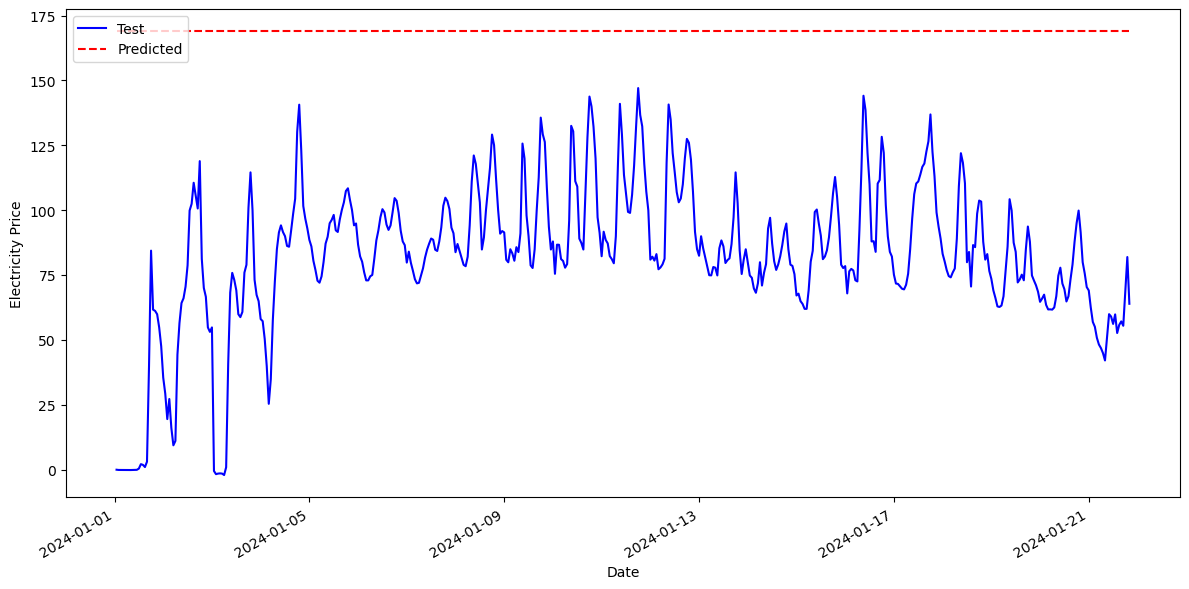

In [95]:
compare_preds(test_df['price'][:500], test_df['pred_mean'][:500])

## Last value

In [96]:
train_df = df_ori.loc['2022-01-01 01:00:00': '2024-01-01 00:00:00', ['price']]
test_df = df_ori.loc['2024-01-01 01:00:00': '2024-11-01 01:00:00', ['price']]

In [97]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2022-01-01 01:00:00 to 2024-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   17520 non-null  float64
dtypes: float64(1)
memory usage: 273.8 KB


In [98]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7320 entries, 2024-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   7320 non-null   float64
dtypes: float64(1)
memory usage: 114.4 KB


In [99]:
X_train, y_train = create_sequences(train_df)

In [100]:
X_test, y_test = create_sequences(test_df)

In [101]:
y_pred = X_test[:, -1,:].reshape(-1)

In [102]:
X_test.shape

(7296, 24, 1)

In [103]:
y_pred.shape

(7296,)

In [104]:
eva_s(y_test, y_pred+0.0000001)

Mean Absolute Error (MAE): 12.23
Root Mean Squared Error (RMSE): 18.33
Symmetric Mean Absolute Percentage Error (sMAPE): 30.59


(12.230744257428729, 18.330042804109564, 30.591837614901348)

## Simple LSTM

In [105]:
df_ori = load_data('df_actual_22_24_cleaned')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    24840 non-null  float64
 1   solar                    24840 non-null  int64  
 2   wind_onshore             24840 non-null  int64  
 3   wind_offshore            24840 non-null  int64  
 4   total_load               24840 non-null  int64  
 5   actual_solar             24840 non-null  int64  
 6   actual_wind_onshore      24840 non-null  int64  
 7   actual_wind_offshore     24840 non-null  int64  
 8   actual_fossil_gas        24840 non-null  int64  
 9   actual_fossil_hard_coal  24840 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 2.1 MB
None


In [106]:
train_df = df_ori.loc['2022-01-01 01:00:00': '2024-01-01 00:00:00', ['price']]
test_df = df_ori.loc['2024-01-01 01:00:00': '2024-11-01 01:00:00', ['price']]

In [107]:
train_df[:5]

,price
2022-01-01 01:00:00,124.70
2022-01-01 02:00:00,124.70
2022-01-01 03:00:00,134.00
2022-01-01 04:00:00,58.80
2022-01-01 05:00:00,37.67


In [108]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Input
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.optimizers import Adam
# # Assuming 'df' is your dataframe with 'price' and a DateTime index
# # Filter and split data into training and test sets
# train_data = df['2022':'2023'][['price']].values
# test_data = df['2024'][['price']].values

# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_df)
scaled_test = scaler.transform(test_df)

# Create sequences for the training set
sequence_length = 24
X_train, y_train = [], []

for i in range(sequence_length, len(scaled_train)):
    X_train.append(scaled_train[i - sequence_length:i, 0])
    y_train.append(scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
# model_basic_LSTM = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(LSTM(units=50))
# model.add(Dense(units=1))
model_basic_LSTM = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=32, return_sequences=False),
        Dense(units=1)
    ])

# Compile the model
model_basic_LSTM.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model_basic_LSTM.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
# Train the model
model_basic_LSTM.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0112
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0020
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0013
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 7.8564e-04
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6.2977e-04
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 5.4557e-04
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.1566e-04
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 4.8676e-04
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 4.8264e-04
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 4.3879e-04
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 4.3969e-04
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 4.3289e-04
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 4.2409e-04
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 4.3158e-04

In [110]:
# Prepare the test set sequences
X_test, y_test = [], []

# Use scaled_test for creating sequences in the test set
for i in range(sequence_length, len(scaled_test)):
    X_test.append(scaled_test[i - sequence_length:i, 0])
    y_test.append(scaled_test[i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict on test set
predicted_price_basic = model_basic_LSTM.predict(X_test)
predicted_price_basic = scaler.inverse_transform(predicted_price_basic)  # Rescale to original values


# Rescale the actual test prices for comparison
actual_price_basic = scaler.inverse_transform(scaled_test[sequence_length:])

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [111]:
eva_s(actual_price_basic, predicted_price_basic) # 12.46

Mean Absolute Error (MAE): 12.46
Root Mean Squared Error (RMSE): 16.80
Symmetric Mean Absolute Percentage Error (sMAPE): 31.84


(12.460995019864846, 16.80005416918687, 31.844957751324237)

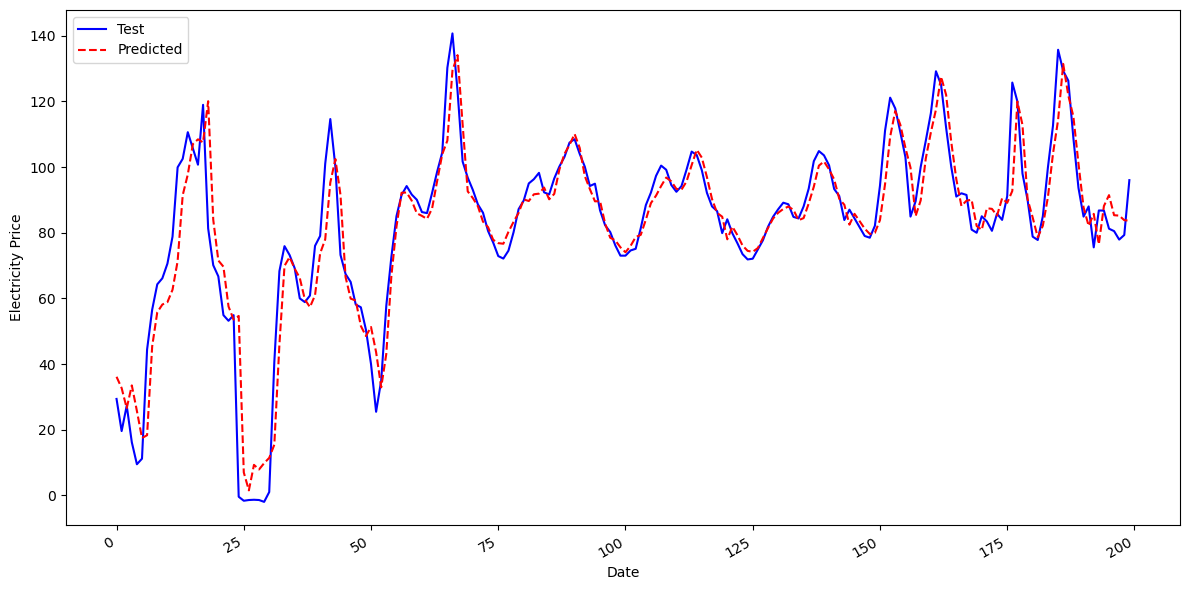

In [112]:
compare_preds(actual_price[:200], predicted_price[:200])

## Lagged LSTM

In [113]:
df_ori = load_data('df_actual_22_24_cleaned')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    24840 non-null  float64
 1   solar                    24840 non-null  int64  
 2   wind_onshore             24840 non-null  int64  
 3   wind_offshore            24840 non-null  int64  
 4   total_load               24840 non-null  int64  
 5   actual_solar             24840 non-null  int64  
 6   actual_wind_onshore      24840 non-null  int64  
 7   actual_wind_offshore     24840 non-null  int64  
 8   actual_fossil_gas        24840 non-null  int64  
 9   actual_fossil_hard_coal  24840 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 2.1 MB
None


In [114]:
df = df_ori[['price']]

In [115]:
# Define the lags you want to explore
lags = [1, 2, 25]
# features = ['price','wind_onshore', 'wind_offshore', 'solar', 'total_load']
features = ['price']
# features = ['wind_onshore', 'wind_offshore', 'solar', 'total_load']
# features = ['price']

# Create lagged features for each feature at specified lags
for feature in features:
    for lag in lags:
        df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)

/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_2130/2016342376.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_2130/2016342376.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)
/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_2130/2016342376.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [116]:
df = df.dropna()

In [117]:
train_df = df.loc['2022-01-01 01:00:00': '2024-01-01 00:00:00', :]
test_df = df.loc['2024-01-01 01:00:00': '2024-11-01 01:00:00', :]

In [118]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Input
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.optimizers import Adam
# # Assuming 'df' is your dataframe with 'price' and a DateTime index
# # Filter and split data into training and test sets
# train_data = df['2022':'2023'][['price']].values
# test_data = df['2024'][['price']].values

train_df = df.loc['2022-01-01 01:00:00': '2024-01-01 00:00:00', :]
test_df = df.loc['2024-01-01 01:00:00': '2024-11-01 01:00:00', :]

# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_df)
scaled_test = scaler.transform(test_df)

# Create sequences for the training set
sequence_length = 24  # Define lag as 24 timesteps
X_train, y_train = [], []

for i in range(sequence_length, len(scaled_train)):
    # Use all columns as features, target is the first column (e.g., 'price')
    X_train.append(scaled_train[i - sequence_length:i])  # All features in lagged window
    y_train.append(scaled_train[i, 0])  # Assuming target is in the first column

X_train, y_train = np.array(X_train), np.array(y_train)

# Create sequences for the testing set
X_test, y_test = [], []

for i in range(sequence_length, len(scaled_test)):
    X_test.append(scaled_test[i - sequence_length:i])  # All features in lagged window
    y_test.append(scaled_test[i, 0])  # Assuming target is in the first column

X_test, y_test = np.array(X_test), np.array(y_test)

# Build the LSTM model
model_lagged_LSTM = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=64, return_sequences=True),
    Dropout(0.2),
    LSTM(units=32, return_sequences=False),
    Dense(units=1)
])

# Compile the model
model_lagged_LSTM.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Summary of the model
model_lagged_LSTM.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 24, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,113 (117.63 KB)

 Trainable params: 30,113 (117.63 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
# Train the model
model_lagged_LSTM.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Make predictions
predictions = model_lagged_LSTM.predict(X_test)


Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0066
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0016
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 8.6767e-04
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6.8695e-04
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6.2859e-04
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.6273e-04
Epoch 7/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 4.9048e-04
Epoch 8/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 4.5388e-04
Epoch 9/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 4.3999e-04
Epoch 10/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 4.2887e-04
Epoch 11/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 4.3252e-04
Epoch 12/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 4.1957e-04
Epoch 13/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 4.1664e-04
Epoch 14/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 4.1603

In [120]:
# Inverse transform predictions and actual values
actual_price_lagged = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), 3))], axis=1))[:, 0] 

predicted_price_lagged = scaler.inverse_transform(
    np.concatenate([predictions, np.zeros((len(predictions), 3))], axis=1))[:, 0]

In [121]:
eva_s(actual_price, predicted_price)

Mean Absolute Error (MAE): 9.54
Root Mean Squared Error (RMSE): 14.27
Symmetric Mean Absolute Percentage Error (sMAPE): 26.57


(9.53947944801488, 14.269609113737637, 26.566696609318385)